# Part 3. Tensorflow tutorial - Image segmentation

### Goal of this tutorial:
###     Build and train a model which segments aorta in CT images

## (1) Labelling train images

In [1]:
# Create ground-truth mask image on Slicer software

In [2]:
import nibabel as nb
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.models import Sequential
import tensorflow as tf

%matplotlib inline

In [3]:
import glob
import shutil
import os
import random
from PIL import Image

#import seaborn as sns

import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split,StratifiedKFold

In [4]:
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


In [6]:
! pip install -U scikit-image[optional]

In [7]:
import os #for accessing the file system of the system
import random
from skimage import io
from skimage.transform import resize
import numpy as np
import keras

In [8]:
import os  # for accessing the file system of the system
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#import segmentation_models as sm
#from segmentation_models.utils import set_trainable
#from dataset import DataGenerator

In [117]:
# Load train images
dataset_dir = ...

In [9]:
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [10]:
# Load train images

ct_dir = './local_ct_total_data'
ct_filelist = [os.path.join(ct_dir,file) 
                  for file 
                  in os.listdir(ct_dir) 
                  if file.endswith('nii')]

print('number of slices : {0}'.format(len(ct_filelist)))

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: './local_ct_total_data'

In [ ]:
ct_filelist

In [11]:
# Load train images

segmentation_dir = './local_segmentation_total_data'
segmentation_filelist = [os.path.join(segmentation_dir,file) 
                  for file 
                  in os.listdir(segmentation_dir) 
                  if file.endswith('nii')]

print('number of slices : {0}'.format(len(segmentation_filelist)))

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: './local_segmentation_total_data'

In [127]:
segmentation_filelist

['./local_segmentation_total_data\\Segmentation (1).nii',
 './local_segmentation_total_data\\Segmentation (10).nii',
 './local_segmentation_total_data\\Segmentation (11).nii',
 './local_segmentation_total_data\\Segmentation (12).nii',
 './local_segmentation_total_data\\Segmentation (13).nii',
 './local_segmentation_total_data\\Segmentation (14).nii',
 './local_segmentation_total_data\\Segmentation (15).nii',
 './local_segmentation_total_data\\Segmentation (16).nii',
 './local_segmentation_total_data\\Segmentation (17).nii',
 './local_segmentation_total_data\\Segmentation (18).nii',
 './local_segmentation_total_data\\Segmentation (19).nii',
 './local_segmentation_total_data\\Segmentation (2).nii',
 './local_segmentation_total_data\\Segmentation (20).nii',
 './local_segmentation_total_data\\Segmentation (21).nii',
 './local_segmentation_total_data\\Segmentation (22).nii',
 './local_segmentation_total_data\\Segmentation (23).nii',
 './local_segmentation_total_data\\Segmentation (24).nii',

In [128]:
 #이 과정 왜하는지 기억안남(찾아보기)

ct_list=[]
    
    
for (root, directories, files) in os.walk(ct_dir):
    for d in directories:
        d_path = os.path.join(root, d)
        #print(d_path)

    for file in files:
        file_path = os.path.join(root, file)
        ct_list.append(file_path)


In [129]:
segmentation_list=[]
    
    
for (root, directories, files) in os.walk(segmentation_dir):
    for d in directories:
        d_path = os.path.join(root, d)
        #print(d_path)

    for file in files:
        file_path = os.path.join(root, file)
        segmentation_list.append(file_path)



In [ ]:
# Visualize sample CT and segmentation images 두개 겹치게 놓던가 쌍으로 나오게 하기

sample_ct = nb.load(...)
sample_ct = sample_ct.get_fdata()
sample_ct = sample_ct[:,:,100]

window_set = {'lung' : (-750-1500/2, -750+1500/2), 'abdomen' : (50-250/2, 50+250/2),
              'mediastinum' : (45-450/2, 45+450/2), 'bone' : (500-2000/2, 500+2000/2),
              'brain' : (40-70/2, 40+70/2), 'pelvis' : (45-300/2, 45+300/2)}

plt.figure(figsize=(8, 8))
plt.imshow(sample_ct.T, cmap='gray', vmin=window_set['mediastinum'][0], vmax=window_set['mediastinum'][1])

In [ ]:
sample_mask = nb.load(...)
sample_mask = sample_mask.get_fdata()
sample_mask = sample_mask[:,:,100]

plt.figure(figsize=(8, 8))
plt.imshow(sample_mask.T, cmap='gray')

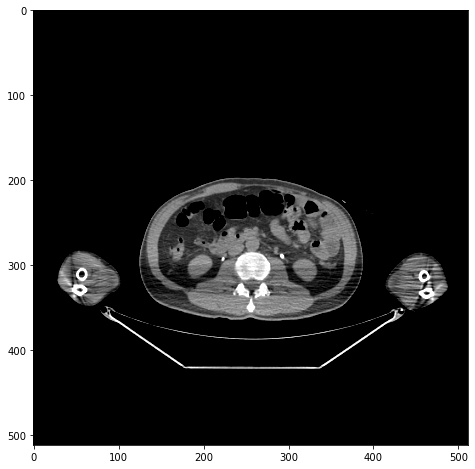

In [130]:
# Visualize sample CT and segmentation images 두개 겹치게 놓던가 쌍으로 나오게 하기

sample_ct1 = nb.load(ct_list[0])
sample_ct2 = sample_ct1.get_fdata()
sample_ct = sample_ct2[:,:,100]

window_set = {'lung' : (-750-1500/2, -750+1500/2), 'abdomen' : (50-250/2, 50+250/2),
              'mediastinum' : (45-450/2, 45+450/2), 'bone' : (500-2000/2, 500+2000/2),
              'brain' : (40-70/2, 40+70/2), 'pelvis' : (45-300/2, 45+300/2)}
#mediastinum이 제일 잘보임
plt.figure(figsize=(8, 8))
plt.imshow(sample_ct.T, cmap='gray', vmin=window_set['mediastinum'][0], vmax=window_set['mediastinum'][1])

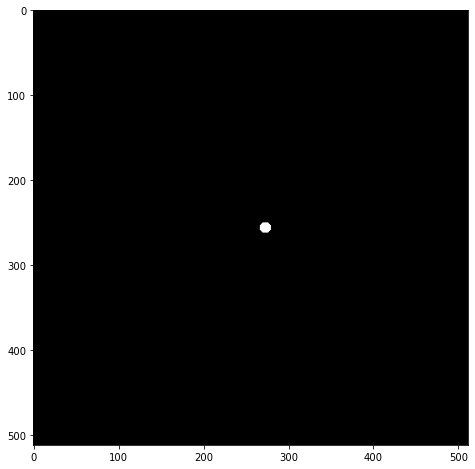

In [131]:
sample_mask1 = nb.load(segmentation_list[0])
sample_mask2 = sample_mask1.get_fdata()
sample_mask = sample_mask2[:,:,100]

plt.figure(figsize=(8, 8))
plt.imshow(sample_mask.T, cmap='gray')

In [132]:
ct_list

['./local_ct_total_data\\CT (1).nii',
 './local_ct_total_data\\CT (10).nii',
 './local_ct_total_data\\CT (11).nii',
 './local_ct_total_data\\CT (12).nii',
 './local_ct_total_data\\CT (13).nii',
 './local_ct_total_data\\CT (14).nii',
 './local_ct_total_data\\CT (15).nii',
 './local_ct_total_data\\CT (16).nii',
 './local_ct_total_data\\CT (17).nii',
 './local_ct_total_data\\CT (18).nii',
 './local_ct_total_data\\CT (19).nii',
 './local_ct_total_data\\CT (2).nii',
 './local_ct_total_data\\CT (20).nii',
 './local_ct_total_data\\CT (21).nii',
 './local_ct_total_data\\CT (22).nii',
 './local_ct_total_data\\CT (23).nii',
 './local_ct_total_data\\CT (24).nii',
 './local_ct_total_data\\CT (25).nii',
 './local_ct_total_data\\CT (26).nii',
 './local_ct_total_data\\CT (27).nii',
 './local_ct_total_data\\CT (28).nii',
 './local_ct_total_data\\CT (29).nii',
 './local_ct_total_data\\CT (3).nii',
 './local_ct_total_data\\CT (30).nii',
 './local_ct_total_data\\CT (31).nii',
 './local_ct_total_data\\CT 

In [133]:
segmentation_list

['./local_segmentation_total_data\\Segmentation (1).nii',
 './local_segmentation_total_data\\Segmentation (10).nii',
 './local_segmentation_total_data\\Segmentation (11).nii',
 './local_segmentation_total_data\\Segmentation (12).nii',
 './local_segmentation_total_data\\Segmentation (13).nii',
 './local_segmentation_total_data\\Segmentation (14).nii',
 './local_segmentation_total_data\\Segmentation (15).nii',
 './local_segmentation_total_data\\Segmentation (16).nii',
 './local_segmentation_total_data\\Segmentation (17).nii',
 './local_segmentation_total_data\\Segmentation (18).nii',
 './local_segmentation_total_data\\Segmentation (19).nii',
 './local_segmentation_total_data\\Segmentation (2).nii',
 './local_segmentation_total_data\\Segmentation (20).nii',
 './local_segmentation_total_data\\Segmentation (21).nii',
 './local_segmentation_total_data\\Segmentation (22).nii',
 './local_segmentation_total_data\\Segmentation (23).nii',
 './local_segmentation_total_data\\Segmentation (24).nii',

In [190]:
from IPython.display import Image, display 
from tensorflow.keras.preprocessing.image import load_img 
import PIL 
from PIL import ImageOps 

# 9번째 이미지를 봅시다. display
(Image(filename=ct_filelist[9])) 

# auto-contrast를 적용한 target: segmentation mask 이미지를 봅시다.
# mask의 값들을 실제로 보면, 0,1,2 이렇게 굉장히 비슷한 값을 가집니다. # 그래서 그냥 display하면 육안으로 확인하기가 힘들어 auto-contrast를 적용해서 봅니다. # Display auto-contrast version of corresponding target (per-pixel categories) img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9])) display(img)
# 그래서 그냥 display하면 육안으로 확인하기가 힘들어 auto-contrast를 적용해서 봅니다.

# Display auto-contrast version of corresponding target (per-pixel categories) 
img = PIL.ImageOps.autocontrast(load_img(segmentation_filelist[9]))
display(img)


ValueError: Cannot embed the 'nii' image format

## (2) Define train/validation set

In [ ]:
# Passing whole dataset causes memory issue
# Create Data generator class
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
#한사람당 500mb임 총 50명정도 하려면 gpu가 버티질 못함.
#한꺼번에 모든사람 불러오지 말고 한사람씩 불러오는 클래스
#구글에 "class DataGenerator 대용량"검색
class DataGenerator(...):
    
    def __init__(self,...):
        ...
        ...
        
    def __len__(self):
        ...
        ...
        return ...
        
    def __getitem__(self, idx):
        ...
        ...
        return ...

In [ ]:
x =
y =
x_val =
y_val =

In [217]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, ct_filelist,segmentation_filelist):
        self.batch_size = batch_size
        self.img_size = img_size
        self.ct_filelist = ct_filelist
        self.segmentation_filelist = segmentation_filelist
        
    def __len__(self):
        return len(self.segmentation_filelist) // self.batch_size
        
    def __getitem__(self, idx,arg):#idx=index
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_ct_filelist = self.ct_filelist[i : i + self.batch_size]
        batch_segmentation_filelist = self.segmentation_filelist[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_ct_filelist):
            img = load_img(path, segmentation_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_segmentation_filelist):
            img = load_img(path, segmentation_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [60]:
x =  DataGenerator(ct_list,ct_list,segmentation_list) #ct
#y =   #segmentation(mask)
#x_val = #아직 안해놓음
#y_val =

## (3) Build and train a model

### Method 1 : U-Net

In [ ]:
# U-Net : https://arxiv.org/abs/1505.04597
# input shape = output shape : (batch_size, 512, 512, 1)

def unet():
    # encoding + decoding layer with skip connection
    # Fully convolutional network without dense layer 
    # FCN : https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
    
    # tf.keras.layers.Conv2D
    # tf.keras.layers.MaxPool2D
    # tf.keras.layers.BatchNormalization
    # tf.keras.layers.ReLu
    # tf.keras.layers.Conv2DTranspose or tf.keras.layers.UpSampling2D + tf.keras.layers.Conv2D
    # tf.concat
    # Sigmoid activation at last layer
    
    ...
    ...
    
    return model

In [207]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [208]:
import random

# Split our img paths into a training and a validation set
val_samples = 10
random.Random(10).shuffle(ct_filelist)
random.Random(10).shuffle(segmentation_filelist)
train_ct_filelist = ct_filelist[:-val_samples]
train_segmentation_filelist = segmentation_filelist[:-val_samples]
val_ct_filelist = ct_filelist[-val_samples:]
val_segmentation_filelist = segmentation_filelist[-val_samples:]


In [209]:
train_gen = DataGenerator(
    batch_size, img_size, train_ct_filelist, train_segmentation_filelist
)
val_gen = DataGenerator(batch_size, img_size, val_ct_filelist, val_segmentation_filelist)

In [210]:
#Train the model

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("aorta_segmentation.h5", save_best_only=True)
]



In [218]:
# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

TypeError: load_img() got an unexpected keyword argument 'segmentation_size'

### Method 2 : 3D U-Net

In [ ]:
# 3D Unet : https://arxiv.org/abs/1606.06650
# input shape : (batch_size, 512, 512, height, 1)

def unet_3D():
    
    # tf.keras.layers.Conv3D
    # tf.keras.layers.MaxPool3D
    # tf.keras.layers.BatchNormalization
    # tf.keras.layers.ReLu
    # tf.keras.layers.Conv3DTranspose or tf.keras.layers.UpSampling3D + tf.keras.layers.Conv3D
    # tf.concat
    # Sigmoid activation at last layer
    
    ...
    ...
    
    return model

In [ ]:
# define a optimizer/metrics and compile the model

model.compile(...)


# print summary of this model
model.summary()

In [ ]:
# Start training

model_history = model.fit(...)

## (4) Plot loss and metrics

In [ ]:
model_history.epoch
model_history.history





## (5) Predict on test set images

In [ ]:
model.predict()

## (6) Saving & loading the trained model

In [ ]:
model.save(...)

## (7) Debugging model/dataset